ACTIAN VECTOR TUTORIAL
============

In this post, we're going to show you how to install and run big data analytics using [Actian Vector](https://www.actian.com/analytic-database/vector-smp-analytic-database/) columnar database using Jupyter Notebooks. Compared to traditional row-oriented databases, columnar databases like Vector really shine on analytics tasks where you need to do a lot of aggregate operations across many rows. Actian Vector in particular leverage modern processor architecture (multi-core and SIMD instructions) to heavily paralellize the workload and speed-up calculations.

Installing Actian Vector
------------------------

We'll work in a *Ubuntu Linux 64-bit 16.06 LTS* machine. We'll also assume you're using `bash`. Vector should work on any recent Linux distro so adapt the instructions below as needed. To install Actian Vector, we're going to follow the "Getting Started" section of the [official documentation](http://docs.actian.com/vector/5.0/index.html). First install the system dependencies, namely *LibAIO*

```bash
sudo apt install libaio1
```

Download [Actian Vector Community Edition] (https://www.actian.com/lp/vector-community-edition/) that allows you 1TB of data without any time limit. After receiving the download link by email and fetching the install `tgz` file, uncompress and run the `install.sh` as super-user then follow instructions.

```bash
tar xvf ~/Downloads/actian-vector-5.0.0-405-community-linux-x86_64.tgz
cd actian-vector-5.0.0-405-community-linux-x86_64/
sudo ./install.sh
```

The default answers will install under `/opt/Actian/VectorVW` (server code `VW`) and create an `actian` user on your machine. Now let's run some post-installation commands to setup Vector as a system service.

```bash
sudo -u actian bash -c 'source ~actian/.ingVWsh && mkrc'
sudo cp /opt/Actian/VectorVW/ingres/files/rcfiles/actian-vectorVW /etc/init.d/
sudo systemctl enable actian-vectorVW
sudo systemctl start actian-vectorVW

```

Now you can use the regular `systemctl` commands to `start` and `stop` your `actian-vectoVW` service. Most administrative commands are run under the created `actian` user. We'll also `source` a small shell script (created during install) that setup `PATH` and other enviroment variables. Use the command below to run Vector commands as `actian` user and test the server is up and running.

```bash
sudo -u -i actian

# as "actian" user
source ~/.ingVWsh
echo 'select 1\g' | sql iidbdb
```

This should output something like:

```
* Executing . . .


┌──────┐
│col1  │
├──────┤
│     1│
└──────┘
(1 row)
continue
* 
Your SQL statement(s) have been committed.
```
If you get an error like `E_LQ0001 Failed to connect to DBMS session.`, it means your server is not running or something went wrong during installation.


Creating a new test database 
----------------------------

We're going to use the `createdb` command to create a new `testdb` database and setup ODBC connection.

```bash
sudo -u -i actian

## as "actian" user
createdb testdb
iiodbcadmin add testdb
iiodbcadmin test testdb
```

The last command should output `iiodbcadmin: Connection was successful.` Now we're going to grant permission on the DB to your user using the SQL `CREATE USER` and `GRANT` statements. In the SQL commands below, replace `<user>` with the name of the OS user account that will run the Jupyter Notebook.

```bash
## as "actian" user
echo 'CREATE USER <user> WITH NOPROFILE, NOGROUP, NOEXPIRE_DATE, NOSECURITY_AUDIT \g' | sql iidbdb
echo 'GRANT ALL PRIVILEGES ON DATABASE testdb TO <user> \g' | sql iidbdb
```


Installing Python dependencies
------------------------------

If you don't already have an *Anaconda Python 3.6* environment ready, install one using *Anaconda* package manager. Download Anaconda (or Miniconda if you prefer) from the [official download site](https://www.continuum.io/downloads). Then just run the command below and follow the instructions:

```bash
bash Anaconda3-4.4.0-Linux-x86_64.sh
```

The default (and assumed) install location is `~/anaconda3`. We're going to create a new virtual environment named `vector` just for this tutorial and activate it:

```bash
~/anaconda3/bin/conda create -y -n vector
source ~/anaconda3/bin/activate vector
```

This will give you a Bash prompt with `(vector)` string prepended. Now install the `conda` dependencies by running the command below:

```bash
## in (vector) virtualenv
conda install -y jupyter pandas pyodbc matplotlib seaborn tqdm
conda install -c conda-forge turbodbc=2.0.0
```

Running (this) Jupyter Notebook
-----------------------------------

Before running the Jupyter server, we need setup the environment variables as the user that will run the Jupyter notebook.

```bash
source ~actian/.ingVWsh
export ODBCSYSINI=/opt/Actian/VectorVW/ingres/files

## test we can connect to Vectian as the non-admin user
iiodbcadmin test testdb
```

Activate the `vector` virtual environment we created before, start the Jupyter server and open this `ActianVector.ipynb` notebook. 

```bash
## in the directory containing the .ipynb file and code
source ~/anaconda3/bin/activate vector

## in (vector) virtualenv
jupyter notebook .
```


Connecting to Vector using "turbodbc"
---------------------------------

The `turbodbc` is a DBAPI2 compatible Python library to connect to datasources providing an ODBC driver. The code below will connect to Vector and issue a sample SQL statement. I picked `turbodbc` because it's more performant but if you prefer, you can use good ol' `pyodbc`, they're API are essentially the same.

In [1]:
import turbodbc as odbc

# Connect to the pre-configured data source
conn = odbc.connect('testdb')

# Create a cursor and execute a statement.
cursor = conn.cursor()
cursor.execute('SELECT 1 as test_col')
res = cursor.fetchone()

print('Result:', res)

Result: [1]


Use Case: Smart energy metering logs
------------------------------------

Our test data will simulate an IoT analytics application. Our fictional company runs analytic queries over a fleet of smart energy meters each sending daily records. Data consists of energy consumption (in kWh), max and min voltage levels (in V) and a flag indicating an outage/brown-out. 

### Schema creation
The data is modeled after a typical "Star Schema" with a `metering_fact` fact table, and `customer_dim` and `date_dim` dimensions, as shown by the diagram below:

<p>
<img src="schema.png">
<p>

Let's create the schema now:

In [ ]:
date_dim_ddl = """
create table date_dim(
    skey integer4,
    date ansidate,
    day integer1,
    month integer1,
    year integer2,
    day_of_week integer1,
    week integer1,
    quarter integer1
)
"""

customer_dim_ddl = """
create table customer_dim(
    skey integer4,
    zipcode integer4,
    county varchar(255),
    state varchar(2)
)
"""

metering_fact_ddl = """
create table metering_fact(
    customer_skey integer4,
    date_skey integer4,
    consumption integer4,
    min_voltage integer2,
    max_voltage integer2,
    outage integer1
)
"""

cursor.execute(date_dim_ddl)
cursor.execute(customer_dim_ddl)
cursor.execute(metering_fact_ddl)
conn.commit()


We're not using any sort of index or constraint in the data model. First, Vector has it's own optimization for anaytical queries that generally doesn't require explict indexes. As for constraints, they have a performance impact on load and it's common to delegate data integrity to the ETL process instead of having it on the database on anaytical workloads.

### Data loading

The "customer" data is sampled randomly from a list of zip codes from the "New England" region of the US (Maine, Vermont, New Hampshire, Massachusetts, Rhode Island, and Connecticut) until we get about 500 thousand "customers". Then we generate daily measurements for each customer for two years (2015 and 2016) giving us about 365 million rows, or about 6.5 GB of data. The measurements are generated from a gaussian distribution with higher average consumption in winter and summer months.


In [2]:
from vector_tutorial import load_data
load_data(conn)


365500000/|/100%|| 365500000/365500000 [28:50<00:00, 224832.54it/s]

The actual implementation code is in the `vector_tutorial.py` file. A note about the implementation: as you can see above, loading `customer_dim` is much slower (~16K records/sec) than loading `metering_fact` (~224K records/sec!). The reason is that I'm using the ODBC layer with `INSERT` statements for loading customers, and the `COPY` statement to load measurements. As expected, the `COPY` is much faster and should be preferred when loading large amounts of data.

### Querying and visualizing

First, let's issue the simplest possible query. We'll use Pandas nice integration with both DBAPI2 API and Jupyter to show nice plots and tables effortlesly.

In [25]:
%%time
import pandas as pd
s = ('SELECT count(*) as row_count FROM metering_fact')
df = pd.read_sql(s, conn)

CPU times: user 16 ms, sys: 136 ms, total: 152 ms
Wall time: 173 ms


In [26]:
df

,row_count
0,365500000


Ok. We got subsecond response from a simple `count`. Of course, that could've come from table statistics so, let's issue a sum over three measurement columns.

In [27]:
%%time
s = ('SELECT sum(consumption) as sum_con, sum(max_voltage) as sum_max_v, sum(min_voltage) as sum_min_v '
     'FROM metering_fact')
df = pd.read_sql(s, conn)

CPU times: user 12 ms, sys: 232 ms, total: 244 ms
Wall time: 638 ms


In [28]:
df

,sum_con,sum_max_v,sum_min_v
0,10791989455,41923524917,45431185832


Again, subsecond responses! Now, for a more complex query, let's show a*Monthly Consuption in 2015* plot.

In [90]:
%%time
s = ('SELECT d.month, sum(f.consumption) as sum_con '
     'FROM metering_fact as f '
     'JOIN date_dim as d on f.date_skey = d.skey '
     'WHERE d.year = 2015'
     'GROUP BY d.month ')
df = pd.read_sql(s, conn)

CPU times: user 8 ms, sys: 32 ms, total: 40 ms
Wall time: 1.37 s


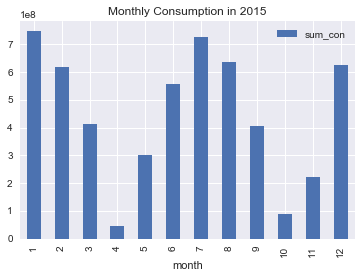

In [91]:
import matplotlib, seaborn
%matplotlib inline
df.plot(kind='bar', x='month', y='sum_con', title="Monthly Consumption in 2015")

Took under 2s in my 5-years old 4-core i5 CPU. Interestingly that we didn't need an explict index to get a performant `JOIN`. Let's try a query likely to be generated by some OLAP tool, crossing "Customer" and "Date" dimensions, slicing by "Date::Year".

In [107]:
%%time
s = ('SELECT c.state, d.quarter, d.month, sum(f.consumption) as sum_con '
     'FROM metering_fact as f '
     'JOIN date_dim as d on f.date_skey = d.skey '
     'JOIN customer_dim as c on f.customer_skey = c.skey '
     'WHERE d.year = 2015 '
     'GROUP BY c.state, d.month, d.quarter ')
df = pd.read_sql(s, conn)

CPU times: user 12 ms, sys: 144 ms, total: 156 ms
Wall time: 4.35 s


In [108]:
pd.crosstab([df.quarter, df.month], df.state, values=df.sum_con, aggfunc='sum', margins=False)

state                 CT         MA         ME        NH        RI         VT
quarter month                                                                
1       1      140775408  224124691  158965612  91317015  29836297  101187632
        2      116819378  186056975  132043288  75721151  24793529   83960479
        3       77539954  123478365   87616043  50274539  16447082   55732771
2       4        8792304   13997671    9931919   5697149   1864610    6317801
        5       56493621   89944467   63832558  36624388  11985460   40597222
        6      104814530  166788091  118380153  67965003  22224247   75292235
3       7      137294579  218470154  155055286  88973715  29100475   98642330
        8      119738564  190574357  135202531  77625179  25411837   86012284
        9       76747619  122175414   86713547  49720138  16286610   55188679
4       10      16985431   27047532   19181663  11007733   3602359   12200451
        11      41918987   66752138   47356951  27180342   8895967   30128187
        12     118029475  187842145  133262890  76428592  25011542   84749122

More important than raw execution speed is the fact that this single query effectively used **all cores** of my CPU. By using some Linux `cpuset` magic and limiting the server to only half the available cores, the query took about double the time. This shows it could scale linearly with the number of CPUS. The usual server grade analytics server, with many more CPUs available should expect subsecond results on this query.

### Conclusion

We've shown how to install, configure, connect and query an Actian Vector database. We loaded a non-trivial amount of data and shown the DB can be performant even on calculation involving multiple `JOIN`s and hundreds of millions of rows on modest hardware, while scaling linearly with the number of CPUs. 

Just as important, the installation process was painless and doesn't require expert Linux or DBA skills. The scripts helped us with systemd and ODBC configuration and everything worked out-of-the-box with no fine-tunning required.
